## Best model

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np

In [3]:
path = '../thermofeeler/data/tokenized_dataset.csv'
df = pd.read_csv(path)

In [4]:
df = df.drop(columns=['Unnamed: 0'])
df_pos = df[df.encoded_sentiment == 1][:7000]
df_neg = df[df.encoded_sentiment == -1][:7000]
df_net = df[df.encoded_sentiment == 0][:7000]

In [5]:
small_df = pd.concat([df_pos, df_neg, df_net])

In [6]:
X = small_df.tweet_text
y = small_df.encoded_sentiment
y = pd.get_dummies(y)

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.7, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14699,), (6301,), (14699, 3), (6301, 3))

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
tk = Tokenizer()
tk.fit_on_texts(X_train)
X_train_token = tk.texts_to_sequences(X_train)
X_train_token[0]

[3, 61, 121, 62, 87, 603, 470, 100, 2546, 67, 1720, 752, 192, 817]

In [9]:
maxLength = max(len(x) for x in X_train_token)
minLength = min(len(x) for x in X_train_token)
vocab_size = len(tk.word_index)
maxLength, minLength, vocab_size

(41, 0, 24625)

In [10]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X_train_pad = pad_sequences(X_train_token, dtype='int32', padding='post', value=0, maxlen=50 )
X_train_pad[0]

array([   3,   61,  121,   62,   87,  603,  470,  100, 2546,   67, 1720,
        752,  192,  817,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

In [12]:
def initialize_model():
    
    reg_l1 = regularizers.L1(0.01)
    reg_l2 = regularizers.L2(0.01)
    reg_l1_l2 = regularizers.l1_l2(l1=0.01, l2=0.01)
    
    opt = optimizers.RMSprop(learning_rate=0.0001)
    
    model = Sequential()
    embedding_size = 200
    model.add(Embedding(input_dim = vocab_size+1, input_length=50,
                        output_dim=embedding_size, mask_zero=True))
    
    model.add(LSTM(50, activation='tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(50, activation='relu', kernel_regularizer=reg_l2))
    model.add(Dropout(0.5))
    model.add(Dense(3, activation="softmax", kernel_regularizer=reg_l2))
    
    model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])

    return model

In [13]:
%%time
model = initialize_model()
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model.fit(X_train_pad, y_train, epochs=200, batch_size=32, verbose=1, callbacks=[es], validation_split=0.2 );

2022-03-24 15:24:47.986276: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/200
368/368 [==============================] - 18s 40ms/step - loss: 1.5150 - accuracy: 0.4709 - val_loss: 1.3695 - val_accuracy: 0.5929
Epoch 2/200
368/368 [==============================] - 13s 36ms/step - loss: 1.1721 - accuracy: 0.6314 - val_loss: 1.0140 - val_accuracy: 0.6408
Epoch 3/200
368/368 [==============================] - 14s 37ms/step - loss: 0.9254 - accuracy: 0.6623 - val_loss: 0.8218 - val_accuracy: 0.6578
Epoch 4/200
368/368 [==============================] - 14s 38ms/step - loss: 0.7637 - accuracy: 0.6768 - val_loss: 0.6996 - val_accuracy: 0.6667
Epoch 5/200
368/368 [==============================] - 15s 42ms/step - loss: 0.6682 - accuracy: 0.6925 - val_loss: 0.6349 - val_accuracy: 0.6857
Epoch 6/200
368/368 [==============================] - 16s 42ms/step - loss: 0.6157 - accuracy: 0.7118 - val_loss: 0.5958 - val_accuracy: 0.7323
Epoch 7/200
368/368 [==============================] - 20s 55ms/step - loss: 0.5761 - accuracy: 0.7567 - val_loss: 0.5612 - val_ac

In [14]:
 model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           4925200   
                                                                 
 lstm (LSTM)                 (None, 50)                50200     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 3)                 153       
                                                                 
Total params: 4,978,103
Trainable params: 4,978,103
Non-

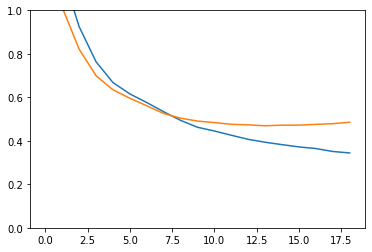

In [15]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylim((0,1));

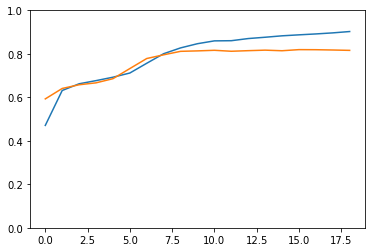

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylim((0,1));

In [17]:
X_test_token = tk.texts_to_sequences(X_test)

In [18]:
X_test_pad = pad_sequences(X_test_token, dtype='int32', padding='post', value=0, maxlen=50 )
X_test_pad[0]

array([699,  16, 554, 158,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [19]:
model.evaluate(X_test_pad, y_test, verbose=0)

[0.4760596454143524, 0.8214569091796875]